<a href="https://colab.research.google.com/github/imishin1/lab_neural_networks/blob/main/emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotional network
## Import libs and get dataset

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch import nn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from pandas.api.types import CategoricalDtype 
import torchvision
import ast

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [3]:
# Инициализируем необходимые датасеты
train_dataset=pd.read_csv('train.csv')
validation_dataset = pd.read_csv('val.csv')
test_dataset = pd.read_csv('test.csv')
sample_dataset = pd.read_csv('sample_submission.csv')

## Предобработка данных

In [4]:
# Приводим pixels к листу с int значениями
train_dataset['pixels'] = [[int(e) for e in x.strip('()').split(' ')] for x in train_dataset['pixels']]
validation_dataset['pixels'] = [[int(e) for e in x.strip('()').split(' ')] for x in validation_dataset['pixels']]
test_dataset['pixels'] = [[int(e) for e in x.strip('()').split(' ')] for x in test_dataset['pixels']]

In [5]:
print(test_dataset)

                                                 pixels     id
0     [170, 118, 101, 88, 88, 75, 78, 82, 66, 74, 68...  32298
1     [7, 5, 8, 6, 7, 3, 2, 6, 5, 4, 4, 5, 7, 5, 5, ...  32299
2     [232, 240, 241, 239, 237, 235, 246, 117, 24, 2...  32300
3     [200, 197, 149, 139, 156, 89, 111, 58, 62, 95,...  32301
4     [40, 28, 33, 56, 45, 33, 31, 78, 152, 194, 200...  32302
...                                                 ...    ...
3584  [50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, 3...  35882
3585  [178, 174, 172, 173, 181, 188, 191, 194, 196, ...  35883
3586  [17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, 2...  35884
3587  [30, 28, 28, 29, 31, 30, 42, 68, 79, 81, 77, 6...  35885
3588  [19, 13, 14, 12, 13, 16, 21, 33, 50, 57, 71, 8...  35886

[3589 rows x 2 columns]


In [6]:
# Проверяем распределение размеров изображений
len_list=list()
for i in train_dataset['pixels']:
    len_list.append(len(i))
pd.DataFrame(len_list).value_counts()
# Все изображения одного размера, соответсевнно дополнительной обработки не требуется  

2304    28709
dtype: int64

## Создание класса собственных датасетов

In [7]:
class CustomDataset(Dataset):
    def __init__(self, train_dataset, device):
        self.X_train = torch.tensor(train_dataset['pixels'], dtype=torch.float32).reshape(len(train_dataset), 1, 48, 48).to(device)
        self.y_train = torch.tensor(train_dataset['emotion']).to(device)
        
    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

class TestDataset(Dataset):
    def __init__(self, test_dataset, device):
        self.X_train = torch.tensor(test_dataset['pixels'], dtype=torch.float32).reshape(len(test_dataset), 1, 48, 48).to(device)
        
    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        return self.X_train[idx]

## Инициализия DataLoader

In [8]:
train = CustomDataset(train_dataset, device)
valid = CustomDataset(validation_dataset, device)
test = TestDataset(test_dataset, device)


train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test, batch_size=128, shuffle=False)

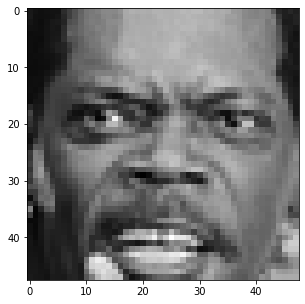

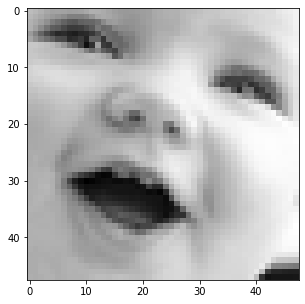

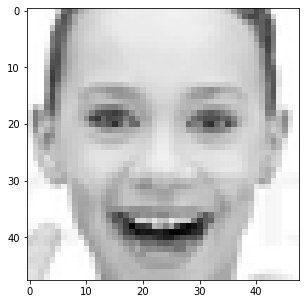

In [9]:
# Проверим, что изображение выводится корректно

plt.figure(figsize=(5,5))
plt.imshow(train.X_train.cpu()[10].reshape(48, 48), cmap='gray')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(valid.X_train.cpu()[10].reshape(48, 48), cmap='gray')
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(test.X_train.cpu()[10].reshape(48, 48), cmap='gray')
plt.show()

## Создание архитектуры нейросети

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.network_stack = nn.Sequential(
          nn.Conv2d(1, 32, 3),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Dropout(0.1),
            
          nn.Conv2d(32, 256, 3),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Dropout(0.1),
            
          nn.Conv2d(256, 256, 3),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Dropout(0.15),
        
          nn.Conv2d(256, 256, 3),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Dropout(0.15),
            
          nn.Conv2d(256, 128, 3),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Dropout(0.1),
        
          nn.Conv2d(128, 32, 3),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
            
          nn.Flatten(),
          nn.Linear(10368, 2048),
          nn.ReLU(),
          nn.Linear(2048, 128),
          nn.ReLU(),
          nn.Linear(128, 7)
        )

    def forward(self, x):
        logits = self.network_stack(x)
        return logits

## Тренировка нейросети

In [11]:
model = NeuralNetwork().to(device)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X).to(device)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

def valid_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).to(device)
            pred_soft=torch.softmax(pred, dim=1).argmax(dim=1)
            valid_loss += loss_fn(pred, y).item()
            correct += (pred_soft == y).type(torch.float).sum().item()
    valid_loss /= num_batches
    correct /= size
    return [correct, valid_loss]

def test_loop(dataloader, model, loss_fn):
    num_elements = len(dataloader.dataset)
    num_batches = len(dataloader)
    batch_size = dataloader.batch_size
    predictions = torch.zeros(num_elements).to(device)
    with torch.no_grad():
        for i, X in enumerate(dataloader):
            pred = model(X).to(device)
            pred_soft=torch.softmax(pred, dim=1).argmax(dim=1)
            start = i*batch_size
            end = start + batch_size
            if i == num_batches - 1:
                end = num_elements
            predictions[start:end] = pred_soft
            
    return predictions


In [12]:
# Инициализируем массивы для отрисовки графиков
epoch_list=list()
accuracy_list=list()
loss_list=list()

# Инициализируем параметры для обучения
learning_rate = 1e-3
epochs = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Обучаем
for t in range(epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer)
    metrics_list=valid_loop(valid_dataloader, model, loss_fn)
    print(f"Epoch {t+1} finished --> Accuracy: {(100*metrics_list[0]):>0.1f}%, Avg loss: {metrics_list[1]:>8f}") 
    epoch_list.append(t)
    accuracy_list.append(metrics_list[0])
    loss_list.append(metrics_list[1])

Epoch 1 finished --> Accuracy: 25.5%, Avg loss: 1.765625
Epoch 2 finished --> Accuracy: 31.7%, Avg loss: 1.709932
Epoch 3 finished --> Accuracy: 36.1%, Avg loss: 1.654058
Epoch 4 finished --> Accuracy: 39.3%, Avg loss: 1.593813
Epoch 5 finished --> Accuracy: 40.7%, Avg loss: 1.549553
Epoch 6 finished --> Accuracy: 42.5%, Avg loss: 1.513963
Epoch 7 finished --> Accuracy: 43.4%, Avg loss: 1.481281
Epoch 8 finished --> Accuracy: 44.1%, Avg loss: 1.461940
Epoch 9 finished --> Accuracy: 45.6%, Avg loss: 1.430694
Epoch 10 finished --> Accuracy: 46.0%, Avg loss: 1.417291
Epoch 11 finished --> Accuracy: 46.0%, Avg loss: 1.395123
Epoch 12 finished --> Accuracy: 46.7%, Avg loss: 1.395373
Epoch 13 finished --> Accuracy: 48.0%, Avg loss: 1.367277
Epoch 14 finished --> Accuracy: 48.5%, Avg loss: 1.348217
Epoch 15 finished --> Accuracy: 48.8%, Avg loss: 1.340833
Epoch 16 finished --> Accuracy: 48.5%, Avg loss: 1.336086
Epoch 17 finished --> Accuracy: 50.4%, Avg loss: 1.317803
Epoch 18 finished --> A

## Метрики

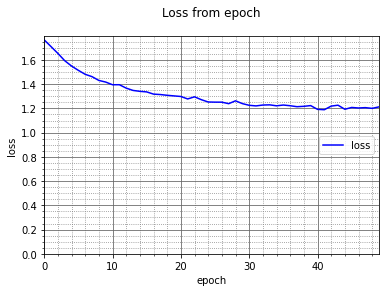

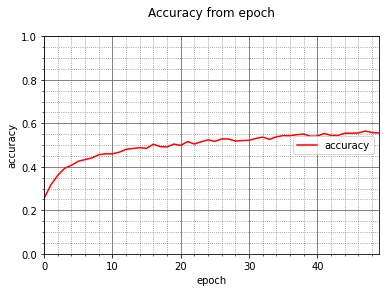

In [13]:
###################################
###  Построение графика потерь  ###
###################################
fig, axes = plt.subplots()


axes.plot(epoch_list, loss_list, color='blue', label='loss')
plt.title('Loss from epoch', pad = 20)
plt.ylabel('loss')
plt.xlabel('epoch')

axes.set_xlim(0, epoch_list[-1])
axes.set_ylim(0)

plt.legend(loc=5)

# Добавление дополнительной ссетки
axes.grid(which='major', color = '#666666')
axes.minorticks_on()
axes.grid(which='minor', color = 'gray', linestyle = ':')


#####################################
###  Построение графика точности  ###
#####################################

fig, axes1 = plt.subplots()

axes1.plot(epoch_list, accuracy_list, color='red', label='accuracy')
plt.title('Accuracy from epoch', pad = 20)
plt.ylabel('accuracy')
plt.xlabel('epoch')

axes1.set_xlim(0, epoch_list[-1])
axes1.set_ylim(0, 1)

plt.legend(loc=5)

# Добавление дополнительной ссетки
axes1.grid(which='major', color = '#666666')
axes1.minorticks_on()
axes1.grid(which='minor', color = 'gray', linestyle = ':')

# Вывод отрисовки на экран
plt.show()

## Получение результата на тестовых данных

In [17]:
loss_fn = nn.CrossEntropyLoss()
test_pred = test_loop(test_dataloader, model, loss_fn)


In [18]:
output = sample_dataset
output['emotion'] = test_pred.cpu().type(torch.int)

In [19]:
print(output)

         id  emotion
0     32298        0
1     32299        0
2     32300        6
3     32301        3
4     32302        0
...     ...      ...
3584  35882        6
3585  35883        4
3586  35884        6
3587  35885        0
3588  35886        4

[3589 rows x 2 columns]


In [20]:
output.to_csv('network_test_out.csv', index=False)